In [3]:
from numpy import load
from numpy import array
import numpy as np

import pandas as pd
from pandas import read_csv

from keras.layers import Input, Conv2D
from keras.models import Model
from keras.layers import Dense, Conv1D, Flatten
from keras.models import model_from_json
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten, Dense, Activation
from keras.utils import np_utils

import sklearn.metrics as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import pickle
from multiprocessing import Queue
from h5py import File

import xgboost as xgb
from bayes_opt import BayesianOptimization
import os
import ast 
from itertools import chain
import cv2

 # Loading & Preprocessing

In [4]:
data = load('/Users/ipsitapraharaj/Desktop/CERN/histos_tba.20.npz')
lst = data.files
li = []
di = []
for item in lst:
    di.append(data[item])

In [9]:
orig_data = pd.DataFrame(di[0])
orig_data['y'] = pd.DataFrame(di[1])[0]
data = pd.DataFrame(di[0])
data

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,3190.0,NaN,3546.0,3568.0,NaN,NaN,NaN,3568.0,NaN,3127.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,108.0
1,2865.0,NaN,2622.0,2608.0,NaN,NaN,NaN,2604.0,2600.0,NaN,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,7.0,0.0,84.0
2,NaN,1415.0,1455.0,1440.0,1408.0,1440.0,1460.0,1424.0,NaN,NaN,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,5.0,45.0
3,3484.0,NaN,3328.0,3328.0,3360.0,NaN,NaN,3336.0,NaN,3520.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,5.0,3.0,105.0
4,4867.0,NaN,NaN,4648.0,4688.0,NaN,NaN,4656.0,4696.0,4923.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,146.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272336,2477.0,NaN,2432.0,2422.0,2424.0,NaN,NaN,2424.0,2424.0,NaN,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,77.0
3272337,4328.0,NaN,4232.0,4200.0,4176.0,NaN,NaN,4192.0,NaN,NaN,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,133.0
3272338,4054.0,NaN,4016.0,4000.0,NaN,NaN,NaN,4000.0,3992.0,4066.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,126.0
3272339,NaN,3464.0,3439.0,3468.0,3464.0,3456.0,3468.0,3468.0,NaN,NaN,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,5.0,107.0


Pre- processing Removing unwanted columns and NaN rows
& Bining of absolute values of pt

In [78]:
col = list(filter(lambda x: x%12<5, list(range(84))))
col = list(filter(lambda x: (x-1)%12!=0, col))
col = sorted(list(set(col).difference(list(range(36,47))+list(range(72,83)))))

data = pd.concat([data[col],orig_data.iloc[:,-4:]],axis=1)
data = data.dropna()

data['label'] = abs(1/data['y'])
bins = [data['label'].min(), 10, 25, 100, data['label'].max()]
labels = [1,2,3,4]
data['label'] = pd.cut(data['label'], bins=bins, labels=labels)
data = data.reset_index(drop=True)

X, y = data.iloc[:,:-2],data.iloc[:,-2]
X = (X-X.min())/(X.max()-X.min())

preparing normalized dataset for model

In [88]:
data

,0,2,3,4,12,14,15,16,24,26,...,52,60,62,63,64,84,85,86,y,label
0,3484.0,3328.0,3328.0,3360.0,42.0,41.0,40.0,40.0,-13.000000,0.0,...,2.0,1.0,0.0,1.0,0.0,1.0,1.0,108.0,-0.445613,1
1,3875.0,4008.0,4024.0,4032.0,23.0,24.0,23.0,24.0,7.000000,0.0,...,1.0,0.0,0.0,1.0,1.0,7.0,0.0,84.0,0.352966,1
2,4269.0,4022.0,3976.0,3928.0,10.0,9.0,8.0,8.0,-16.613783,-1.0,...,1.0,0.0,0.0,1.0,1.0,4.0,5.0,45.0,-0.162742,1
3,2096.0,1872.0,1872.0,1910.0,34.0,31.0,31.0,32.0,-13.000000,0.0,...,1.0,1.0,1.0,0.0,0.0,5.0,3.0,105.0,0.181209,1
4,4089.0,4096.0,4098.0,4104.0,9.0,9.0,9.0,9.0,0.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,6.0,1.0,146.0,0.381638,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179351,1827.0,1744.0,1736.0,1736.0,33.0,32.0,32.0,32.0,0.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,3.0,2.0,132.0,-0.165822,1
1179352,2364.0,2408.0,2416.0,2424.0,13.0,12.0,12.0,12.0,-0.000000,0.0,...,1.0,1.0,1.0,0.0,0.0,7.0,0.0,135.0,0.461960,1
1179353,3932.0,3806.0,3776.0,3784.0,25.0,23.0,23.0,23.0,-9.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,4.0,0.0,152.0,0.192746,1
1179354,2477.0,2432.0,2422.0,2424.0,14.0,13.0,13.0,13.0,-5.537928,0.0,...,1.0,1.0,1.0,0.0,0.0,4.0,2.0,120.0,0.078042,2


 # XGB

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)

In [80]:
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [81]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=3, n_iter=20, acq='ei')

|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
|  1        | -0.1006   |  0.5898   |  0.5726   |  6.252    |
|  2        | -0.1047   |  0.3321   |  0.06579  |  3.036    |
|  3        | -0.1005   |  0.8088   |  0.6342   |  6.069    |
|  4        | -0.1006   |  0.9      |  1.0      |  7.0      |
|  5        | -0.1004   |  0.9      |  0.0      |  6.905    |
|  6        | -0.1004   |  0.8881   |  0.01765  |  6.233    |
|  7        | -0.1004   |  0.9      |  0.3127   |  6.512    |
|  8        | -0.1029   |  0.3472   |  0.01955  |  6.993    |
|  9        | -0.1049   |  0.3      |  1.0      |  5.569    |
|  10       | -0.1006   |  0.9      |  0.8306   |  6.468    |
|  11       | -0.1005   |  0.8724   |  0.3703   |  6.106    |
|  12       | -0.1004   |  0.9      |  0.0      |  6.588    |
|  13       | -0.1005   |  0.8653   |  0.5657   |  6.28     |
|  14       | -0.1005   |  0.9      |  0.4804   |  7.0      |
|  15   

In [82]:
sort_orders = sorted([xgb_bo.res[i]['target'] for i in range(len(xgb_bo.res))], reverse = True)

In [83]:
for i in range(len(xgb_bo.res)):
    if (xgb_bo.res[i]['target'] == sort_orders[0]):
        params = xgb_bo.res[i]['params']
    

In [84]:
# params = xgb_bo.res['max']['max_params']
params['max_depth'] = int(params['max_depth'])

In [85]:
pd.DataFrame.from_dict(params,orient ='index').T

,colsample_bytree,gamma,max_depth
0,0.9,0.0,5.0


In [86]:
(pd.DataFrame.from_dict(params,orient ='index').T).to_csv('/Users/ipsitapraharaj/Desktop/CERN/params_20.csv')

In [87]:
# Train a new model with the best parameters from the search
model2 = xgb.train(params, dtrain, num_boost_round=25)

# Predict on testing and training set
y_pred = model2.predict(dtest)
y_train_pred = model2.predict(dtrain)

# Report testing and training RMSE
print(np.sqrt(mean_absolute_error(y_test, y_pred)))
print(np.sqrt(mean_absolute_error(y_train, y_train_pred)))

0.25836173
0.25737038


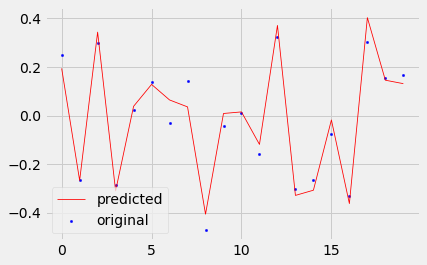

In [64]:
x_ax = range(len(y_pred))
plt.scatter(x_ax[:20], y_test[:20], s=5, color="blue", label="original")
plt.plot(x_ax[:20], y_pred[:20], lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [40]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 4)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred), 4))

Mean absolute error = 19.1209
Mean squared error = 16265.128
Median absolute error = 2.0138
Explain variance score = 0.0271
R2 score = 0.0271


Please run this cell only after loading the trained model

In [74]:
params = pd.read_csv('/Users/ipsitapraharaj/Desktop/CERN/params_20.csv', index_col = 0)
params = params.loc[0,:].to_dict()
params['max_depth'] = int(params['max_depth'])

In [75]:
# Train a new model with the best parameters from the search
model2 = xgb.train(params, dtrain, num_boost_round=25)

# Predict on testing and training set
y_pred = model2.predict(dtest)
y_train_pred = model2.predict(dtrain)

# Report testing and training RMSE
print(np.sqrt(mean_absolute_error(y_test, y_pred)))
print(np.sqrt(mean_absolute_error(y_train, y_train_pred)))

4.3727417
4.3368254


 # ANN
 
 Please download the model_ann.json & model_ann.h5 files to the local directory to run this model
 
 The results are displayed corresponding to each cell

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [41]:
model = Sequential()
model.add(Dense(40, input_dim=19, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(7, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(optimizer = 'adam',loss = 'mae')
model.fit(X_train, y_train, batch_size = 20, epochs = 10)

Epoch 1/10
47175/47175 [==============================] - 119s 3ms/step - loss: 14.8836
Epoch 2/10
47175/47175 [==============================] - 117s 2ms/step - loss: 14.5971
Epoch 3/10
47175/47175 [==============================] - 124s 3ms/step - loss: 14.47620s - loss: 1
Epoch 4/10
47175/47175 [==============================] - 122s 3ms/step - loss: 14.3699
Epoch 5/10
47175/47175 [==============================] - 120s 3ms/step - loss: 14.2723
Epoch 6/10
47175/47175 [==============================] - 120s 3ms/step - loss: 14.1616
Epoch 7/10
47175/47175 [==============================] - 129s 3ms/step - loss: 14.0847
Epoch 8/10
47175/47175 [==============================] - 73s 2ms/step - loss: 13.9943
Epoch 9/10
47175/47175 [==============================] - 67s 1ms/step - loss: 13.9054
Epoch 10/10
47175/47175 [==============================] - 68s 1ms/step - loss: 13.8531


In [42]:
ypred = model.predict(X_test)
print(model.evaluate(X_train, y_train))
print("MAE: %.4f" % sm.mean_absolute_error(y_test, ypred))

29484/29484 [==============================] - 59s 2ms/step - loss: 13.6216
13.62159252166748


In [51]:
# model2 = model
# model2.add(layers.Dense(1, activation='relu'))
# model2.compile(optimizer = 'adam',loss = 'mae')
# model2.fit(X_train, y_train, batch_size = 100, epochs = 10)

In [ ]:
x_ax = range(len(ypred))
plt.scatter(x_ax[:20], y_test[:20], s=5, color="blue", label="original")
plt.plot(x_ax[:20], ypred[:20], lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [ ]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, ypred), 4)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, ypred), 4)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, ypred), 4)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, ypred), 4)) 
print("R2 score =", round(sm.r2_score(y_test, ypred), 4))

In [53]:
# serialize model to JSON
model_json = model.to_json()
with open("model_ann1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_ann1.h5")
print("Saved model to disk")
 
# later...

Saved model to disk


In [54]:
# load json and create model
json_file = open('model_ann1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_ann1.h5")
print("Loaded model from disk")
# loaded_model.pop()
# loaded_model.add(Dense(10, kernel_initializer='normal'))
# loaded_model.add(Dense(6, kernel_initializer='normal'))
# loaded_model.add(Dense(1, kernel_initializer='normal'))
# define new model

Loaded model from disk


In [ ]:
loaded_model.summary()

In [57]:
# Compile model
loaded_model.compile(optimizer = 'adam',loss = 'mae')
loaded_model.fit(X_train, y_train, batch_size = 20, epochs = 20)

Epoch 1/20
47175/47175 [==============================] - 90s 2ms/step - loss: 20.5204
Epoch 2/20
47175/47175 [==============================] - 78s 2ms/step - loss: 20.5204
Epoch 3/20
11533/47175 [======>.......................] - ETA: 1:41 - loss: 20.4278

KeyboardInterrupt: 

Please run this cell only after loading the trained model

In [56]:
# evaluate loaded model on test data
score = loaded_model.evaluate(X_train, y_train, verbose=2)
print("R2 score =", round(sm.r2_score(y_test, loaded_model.predict(X_test)), 4))
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], 100-(score[0]*100)))

29484/29484 - 53s - loss: 20.5203
R2 score = -0.0219


 # CNN 1D
 Please download the model_cnn1.json & model_cnn1.h5 files to the local directory to run this model
 
 The results are displayed corresponding to each cell

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
x = X.to_numpy().reshape(X.to_numpy().shape[0], X.to_numpy().shape[1], 1)
print(x.shape)
x = np.nan_to_num(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

(1179356, 19, 1)


In [70]:
model = Sequential()
model.add(Conv1D(64, 2, activation="relu", input_shape=(x.shape[1:])))
model.add(Conv1D(64, 2, activation="relu"))
model.add(Conv1D(64, 2, activation="relu"))
model.add(Flatten())
model.add(Dense(1, activation="relu"))
model.compile(loss="mae", optimizer="adam")
 
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 18, 64)            192       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 17, 64)            8256      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 16, 64)            8256      
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 1025      
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.fit(X_train, y_train, batch_size=1000,epochs=20, verbose=2)


Epoch 1/20
944/944 - 67s - loss: 14.6169
Epoch 2/20
944/944 - 70s - loss: 14.6145
Epoch 3/20
944/944 - 77s - loss: 14.6129
Epoch 4/20
944/944 - 67s - loss: 14.6122
Epoch 5/20
944/944 - 70s - loss: 14.6131
Epoch 6/20
944/944 - 66s - loss: 14.6097
Epoch 7/20
944/944 - 62s - loss: 14.6074
Epoch 8/20
944/944 - 69s - loss: 14.6051
Epoch 9/20
944/944 - 65s - loss: 14.5990
Epoch 10/20
944/944 - 75s - loss: 14.5956
Epoch 11/20
944/944 - 83s - loss: 14.5916
Epoch 12/20
944/944 - 79s - loss: 14.5856
Epoch 13/20
944/944 - 77s - loss: 14.5798
Epoch 14/20
944/944 - 67s - loss: 14.5682
Epoch 15/20
944/944 - 78s - loss: 14.5518
Epoch 16/20
944/944 - 70s - loss: 14.5287
Epoch 17/20
944/944 - 70s - loss: 14.4983
Epoch 18/20
944/944 - 76s - loss: 14.4636
Epoch 19/20
944/944 - 67s - loss: 14.4276
Epoch 20/20
944/944 - 72s - loss: 14.3856


In [84]:
model3= model2
model3.compile(optimizer='adam',
              loss='mae',
              metrics=['accuracy'])

h1 = model3.fit(X_train, y_train, batch_size=50,epochs=20, verbose=2)

Epoch 1/20
18870/18870 - 126s - loss: 12.4765 - accuracy: 0.0000e+00
Epoch 2/20
18870/18870 - 120s - loss: 12.4391 - accuracy: 0.0000e+00
Epoch 3/20
18870/18870 - 111s - loss: 12.4136 - accuracy: 0.0000e+00
Epoch 4/20
18870/18870 - 112s - loss: 12.4025 - accuracy: 0.0000e+00
Epoch 5/20
18870/18870 - 111s - loss: 12.4155 - accuracy: 0.0000e+00
Epoch 6/20
18870/18870 - 112s - loss: 12.3946 - accuracy: 0.0000e+00
Epoch 7/20
18870/18870 - 112s - loss: 12.3814 - accuracy: 0.0000e+00
Epoch 8/20
18870/18870 - 111s - loss: 12.3671 - accuracy: 0.0000e+00
Epoch 9/20
18870/18870 - 115s - loss: 12.3407 - accuracy: 0.0000e+00
Epoch 10/20
18870/18870 - 117s - loss: 12.3602 - accuracy: 0.0000e+00
Epoch 11/20
18870/18870 - 112s - loss: 12.3083 - accuracy: 0.0000e+00
Epoch 12/20
18870/18870 - 113s - loss: 12.2997 - accuracy: 0.0000e+00
Epoch 13/20
18870/18870 - 121s - loss: 12.2972 - accuracy: 0.0000e+00
Epoch 14/20
18870/18870 - 131s - loss: 12.2892 - accuracy: 0.0000e+00
Epoch 15/20
18870/18870 - 143

In [85]:
ypred = model3.predict(X_test)
print(model.evaluate(X_train, y_train))
 
print("MAE: %.4f" % sm.mean_absolute_error(y_test, ypred))

29484/29484 [==============================] - 96s 3ms/step - loss: 12.2749 - accuracy: 0.0000e+00
[12.274883270263672, 0.0]
MAE: 12.1647


In [86]:
print("R2 score =", round(sm.r2_score(y_test, ypred), 4))

R2 score = 0.0584


In [87]:
# serialize model to JSON
model_json = model.to_json()
with open("model_cnn1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn1.h5")
print("Saved model to disk")
 
# later...

Saved model to disk


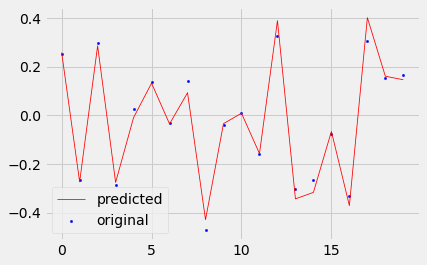

In [27]:
x_ax = range(len(ypred))
plt.scatter(x_ax[:20], y_test[:20], s=5, color="blue", label="original")
plt.plot(x_ax[:20], ypred[:20], lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [28]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, ypred), 4)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, ypred), 4)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, ypred), 4)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, ypred), 4)) 
print("R2 score =", round(sm.r2_score(y_test, ypred), 4))

Mean absolute error = 0.0273
Mean squared error = 0.0016
Median absolute error = 0.0185
Explain variance score = 0.9749
R2 score = 0.9745


In [8]:
 
# load json and create model
json_file = open('model_cnn1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_cnn1.h5")
print("Loaded model from disk")
 

Loaded model from disk


Please run this cell only after loading the trained model

In [9]:
# evaluate loaded model on test data
loaded_model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_train, y_train, verbose=2)

29484/29484 - 74s - loss: 12.2749 - accuracy: 0.0000e+00
